In [1]:
import torch
import sklearn
from sklearn.datasets import make_circles

In [2]:

from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [3]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]

First 5 y labels:
[1 1 1 1 0]


In [4]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


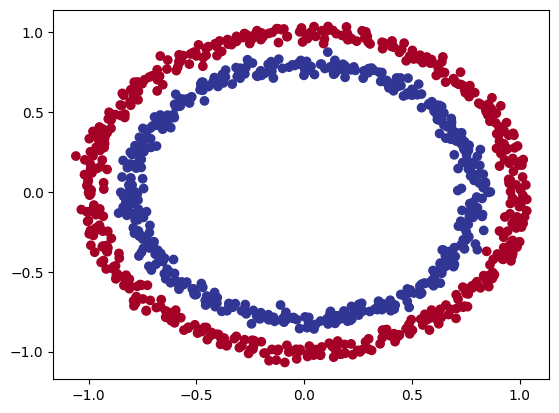

In [5]:
# Visualize with a plot
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu)

In [6]:

# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


In [7]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y , test_size= 0.2 ,random_state=42)

In [9]:
len(X_train) , len(X_test), len(y_train), len(y_test) , n_samples

(800, 200, 800, 200, 1000)


2. Building a model
We've got some data ready, now it's time to build a model.

We'll break it down into a few parts.

Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
Constructing a model by subclassing nn.Module.
Defining a loss function and optimizer.
Creating a training loop (this'll be in the next section).
The good news is we've been through all of the above steps before in notebook 01.

Except now we'll be adjusting them so they work with a classification dataset.

Let's start by importing PyTorch and torch.nn as well as setting up device agnostic code.

In [10]:
# Standard PyTorch imports
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

How about we create a model?

We'll want a model capable of handling our X data as inputs and producing something in the shape of our y data as ouputs.

In other words, given X (features) we want our model to predict y (label).

This setup where you have features and labels is referred to as supervised learning. Because your data is telling your model what the outputs should be given a certain input.

To create such a model it'll need to handle the input and output shapes of X and y.

Remember how I said input and output shapes are important? Here we'll see why.

Let's create a model class that:

Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).
Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
Defines a forward() method containing the forward pass computation of the model.
Instantiates the model class and sends it to the target device.

In [11]:
# Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.layer1 = nn.Linear(in_features= 2, out_features= 5 ) # Takes  in 2 features and upscales to 5
        self.layer2 = nn.Linear(in_features= 5, out_features=  1) # Takes in 5 features prom previoous layer and outputs a single feature  ( same shape as y)

    # Define a forward method that outlines the forwards pass
    def forward(self, x):

        return self.layer_2(self.layer_1(x)) 
    


In [12]:
model = CircleModelV0().to(device)
model

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
model.layer1

Linear(in_features=2, out_features=5, bias=True)

In [14]:

import torch
import torch.nn as nn


class GamblerLoss(nn.Module):
    def __init__(self, inference_will=1.1):
        super().__init__()
        """ Returns a CrossEntropyLoss-like object that has been modified
            according to the DeepGambler paper [1].
        Parameters
        ----------
        inference_will: floating point
            The willingness to infer or abstain.  Greater values make the
            inference more confident, while lower values make abstention more
            likely.  Given m different classes (not inclusive of the abstention
            class), meaningful values are in the range (1, m).
        Notes
        -----
        [1] DeepGamblers: Learning to Abstain with Portfolio Theory. L. Ziyin,
            Z. T. Wang, P. Pu Liang, R. Salakhutdinov, L.P. Morency, M. Ueda.
            NeurIPS, 2019
        """

        self.o = torch.tensor(inference_will)
        self.nllloss = nn.NLLLoss()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, v, labels):
        """ Returns the Gambler loss value
        Parameters
        ----------
        v: a tensor of inputs with dimension BxI
        labels: a tensor with dimension Bx1 of indexes in [0, I-2] of the
                correct label (the I-1-th class is the abstinence one and
                should not be used in training).
        Notes
        -----
        This loss is a Negative Log Likelihood of weighted and scaled
        probabilities (from the Softmax response).  We refer to the log of
        these values as log_gambler_values.
        """

        x = self.log_gambler_values(v)
        return self.nllloss(x, labels)

    def log_gambler_values(self, v):
        """ Returns the log values to be passed to the Negative Log Likelihood
            Loss.
        Parameters
        ----------
        v: a tensor of inputs with dimension BxI
        Notes
        -----
        In order to avoid overflow issues due to exp of a large number, we
        execute it only on arguments lower or equal than 0. In order to avoid
        instability issues due to log of a small number, we execute it only on
        arguments greater or equal than 1.
        Our target values are in the form:
            xi = log (fi*o + fm)
        where fi = exp(vi)/sum(exp(vj)).
        To avoid computing exponential with argument greater than 0 we rescale
        the values wrt. the maximum per the first dimension, indicated as V.
        => fi = exp(vi-V)/sum(exp(vj-V)).
        xi = log[o*exp(vi-V)/sum(exp(vj-V)) + exp(vm-V)/sum(exp(vj-V))]
        vm is the value of the m+1-th class, the abstinence class.
        xi = log[(o*exp(vi-V) + exp(vm-V))/sum(exp(vj-V))]
           = log[o*exp(vi-V)(1 + exp(vm-V)/(exp(vi-V)*o)] - log(sum(exp(vj-V))
           = vi - V + log(o + exp(vm-V)/exp(vi-V)) - log(sum(exp(vj-V))
           = log(o + exp(vm-V)/exp(vi-V)) + log_softmax(v)
        The two exponential must be computed separately as there is no
        guarantee that vm-vi<=0. Being the exponentials greater than 0 and o
        >= 1, it follows the stability constraints are respected.
        """
        maxs = v.max(dim=1)[0]
        lasts = v[:,-1]

        upper = torch.exp(lasts-maxs)
        upside = torch.exp(v.transpose(0, 1).add(-maxs)).div(upper).transpose(0, 1)
        x = 1./upside + self.o
        return self.log_softmax(v) + torch.log(x)


def log_gambler(v, o):
    """
    dummy implementation for testing
    """
    softmax = nn.Softmax(dim=1)
    x = softmax(v)
    z = x[:, -1]
    y = torch.mul(x, o)
    x = y+z.unsqueeze(1)

    x = torch.log(x)  ## could be numerically unstable if probabilities approach zero
    return x


def output2class(model_output, coverage, abstain_class):
    probs = torch.softmax(model_output, dim=1)[:, abstain_class]
    _, predicted = torch.max(model_output[:, :abstain_class], dim=1)
    predicted = (probs < coverage).int().mul(predicted)
    predicted += (probs >= coverage).int().mul(abstain_class)
    return predicted


if __name__ == "__main__":
    v = torch.tensor([[1, 2, 3], [6, 4, 5]], dtype=float)
    o = 1.5
    gl = GamblerLoss(o)

    y = gl.log_gambler_values(v)
    z = log_gambler(v, o)

    print(f"Expected {z}")
    print(f"Computed {y}")

Expected tensor([[-0.2228,  0.0318,  0.5087],
        [ 0.2172, -0.9682, -0.4913]], dtype=torch.float64)
Computed tensor([[-0.2228,  0.0318,  0.5087],
        [ 0.2172, -0.9682, -0.4913]], dtype=torch.float64)


In [15]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.1791, -0.4670],
                      [-0.1089, -0.1700],
                      [ 0.4245, -0.6851],
                      [ 0.3730, -0.1723],
                      [ 0.6284, -0.3362]])),
             ('0.bias', tensor([-0.6449,  0.7026, -0.0893,  0.4509, -0.6026])),
             ('1.weight',
              tensor([[-0.0359,  0.4025, -0.3650,  0.4068, -0.1726]])),
             ('1.bias', tensor([-0.2231]))])

In [17]:
# Make predictions with the model
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[0.5859],
        [0.5794],
        [0.4489],
        [0.6253],
        [0.2043],
        [0.2022],
        [0.3777],
        [0.2887],
        [0.4595],
        [0.5762]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


# Setup loss functions and optimizer

Which loss funcitons and optimizer use 

For Regression : MAE or MSE

for Classification  : Binary corss entropy or categorical corsso entropy

and for optimizers , two  of the most commom and useful are SGD and Adam .


### Sigmoid $(x) = \sigma(x) = \frac{1}{1+exp(-x)}$ 





In [18]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid built-in

# Create an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), 
                            lr=0.1)

In [19]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

### Train model 
Pytorch training loop steps 
* Forward pass - The model goes through all of the training data once, performing its forward() function calculations (model(x_train)).

* Calculate the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train) ).

* Zero gradients - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).

* Perform backpropagation on the loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).

* Step the optimizer (gradient descent) - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).


 1. Forward  pass
 2. Calculate the loss 
 3. Optimizer zero grad
 4. Loss backward( backpropagation )
 5. Optimizer step (gradient descent ) 


## Going from raw logits -> prediction probabilites -> prediction labels

Our model outputs are going to b e war logits

We can convert these logits into prediction probablities by passing them to some kind of activation function ( sigmoid for binary classification and softmax for multiclass classification ).

Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the `argmax()`

In [35]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits


# >>> @torch.inference_mode()
# ... def func(x):
# ...     return x * x
# >>> out = func(x)
# >>> out.requires_grad
# False

tensor([[ 0.0280],
        [ 0.0517],
        [-0.0321],
        [ 0.0450],
        [-0.0287]])

In [36]:
y_logits.squeeze().shape

torch.Size([5])

In [22]:
mae = (( y_test[:5] - y_logits.squeeze() )**2).mean()
mae


tensor(0.3670)

In [23]:
# Use the sigmoid activation function on our model logits to trun them into prediction probabilities

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs


tensor([[0.6424],
        [0.6409],
        [0.6104],
        [0.6514],
        [0.5509]])

For our prediction probability values, we need to perform a range -style rouding on them

* `y_pred_probs` >= 0.5 , `y = 1` class 1
* `y_pred_probs` < 0.5 , `y = 0` class 0

In [24]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full ( logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([1., 1., 1., 1., 1.])

### Building the training and test looping




In [25]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass (model outputs raw logits)
    y_logits = model_0(X_train).squeeze() # squeeze to remove extra `1` dimensions, this won't work unless model and data are on same device 
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labls
  
    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), # Using nn.BCELoss you need torch.sigmoid()
    #                y_train) 
    loss = loss_fn(y_logits, # Using nn.BCEWithLogitsLoss works with raw logits
                   y_train) 
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred) 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards ( back)
    loss.backward()

    # 5. Optimizer step (optimizer the parameters to reduce the gradient)
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71522, Accuracy: 50.00% | Test loss: 0.71614, Test acc: 50.00%
Epoch: 10 | Loss: 0.69866, Accuracy: 50.12% | Test loss: 0.70052, Test acc: 50.50%
Epoch: 20 | Loss: 0.69477, Accuracy: 54.00% | Test loss: 0.69654, Test acc: 54.50%
Epoch: 30 | Loss: 0.69374, Accuracy: 51.75% | Test loss: 0.69535, Test acc: 51.00%
Epoch: 40 | Loss: 0.69341, Accuracy: 51.25% | Test loss: 0.69489, Test acc: 51.00%
Epoch: 50 | Loss: 0.69327, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 50.00%
Epoch: 60 | Loss: 0.69319, Accuracy: 50.38% | Test loss: 0.69455, Test acc: 51.00%
Epoch: 70 | Loss: 0.69314, Accuracy: 50.50% | Test loss: 0.69447, Test acc: 49.50%
Epoch: 80 | Loss: 0.69310, Accuracy: 50.50% | Test loss: 0.69442, Test acc: 47.50%
Epoch: 90 | Loss: 0.69307, Accuracy: 50.75% | Test loss: 0.69438, Test acc: 47.50%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69436, Test acc: 49.00%
Epoch: 110 | Loss: 0.69304, Accuracy: 50.62% | Test loss: 0.69435, Test acc: 47.50%
Epo

In [33]:
y_logits = model_0(X_train).squeeze()
y_logits.shape , X_train.shape

(torch.Size([800]), torch.Size([800, 2]))

In [30]:
y_logits.shape, y_train.shape , X_train.shape

(torch.Size([800]), torch.Size([800]), torch.Size([800, 2]))

In [26]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.
    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [112]:
! pip install torchvision

  Using cached torchvision-0.15.1-cp311-cp311-win_amd64.whl (1.2 MB)



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [113]:
from pathlib import Path
import requests

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exist, skipping  download ")
else :
    print("Download helper_functions.py")

    request  = requests.get("https://raw.githubusercontent.com/JanathanPlanas/pytorch-deep-learning/main/helper_functions.py") 
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)



from helper_functions import plot_decision_boundary, plot_predictions


helper_functions.py already exist, skipping  download 


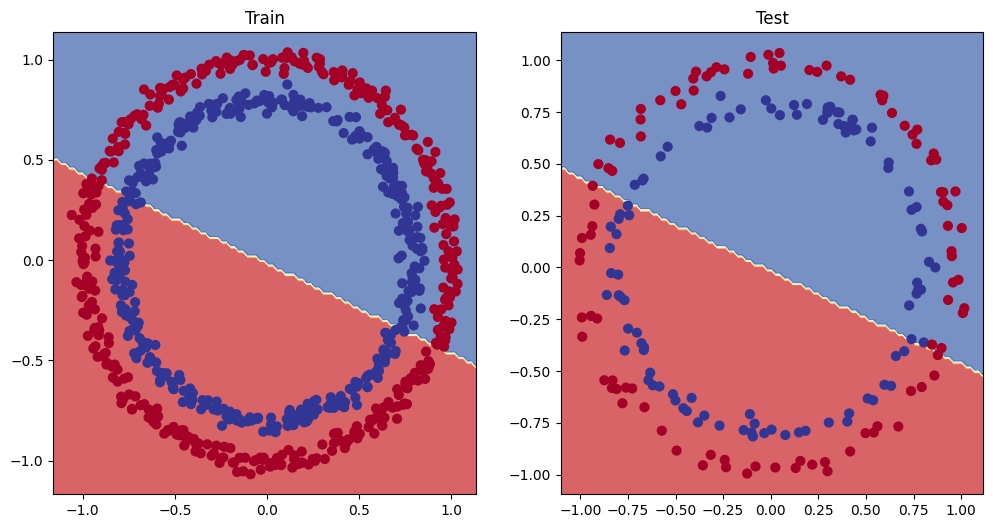

In [97]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Improving a model ( from a model perspective )

* Add more layers - give the model more chances to learn about patterns in the data 

Each layer potentially increases the learning capabilities of the model with each layer being able to learn some kind of new pattern in the data, more layers is often referred to as making your neural network deeper. 

* add more hidden units - go from 5 hidden units to 10 hidden units 

Similar to the above, more hidden units per layer means a potential increase in learning capabilities of the model, more hidden units is often referred to as making your neural network wider.

* Fit for longer 

Your model might learn more if it had more opportunities to look at the data.

* Changing the activation functions

Some data just can't be fit with only straight lines (like what we've seen), using non-linear activation functions can help with this (hint, hint).


* Learning different model  
* Changing the learning rate 

Less model specific, but still related, the learning rate of the optimizer decides how much a model should change its parameters each step, too much and the model overcorrects, too little and it doesn't learn enough.


* Using different training methods
* Changing the loss functions 

Again, less model specific but still important, different problems require different loss functions. For example, a binary cross entropy loss function won't work with a multi-class classification problem.


* Using different optimizers
* Using different regularization methods
* Using different regularization parameters
* Using different batch sizes
* *Use transfer learning*

> Note: because you can adjust all of these by hand, they're referred to as hyperparameters*.

>And this is also where machine learning's half art half science comes in, there's no real way to know here what the best combination of values is for your project, best to follow the data scientist's motto of "experiment, experiment, experiment"

In [98]:
class CircleModelV1(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
        # self.bn1 = nn.BatchNorm2d(32)
        # self.conv2 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2)
        # self.bn2 = nn.BatchNorm2d(32)
        # self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=2)
        # self.bn3 = nn.BatchNorm2d(32)
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10) # extra layer
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        
    def forward(self, x): # note: always make sure forward is spelt correctly!
        # Creating a model like this is the same as below, though below
        # generally benefits from speedups where possible.
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        # return z
        return self.layer_3(self.layer_2(self.layer_1(x)))

model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [99]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1

In [102]:
 
# loss_fn = nn.BCELoss() # Requires sigmoid on input
loss_fn = nn.BCEWithLogitsLoss() # Does not require sigmoid on input
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

# Write a training and evaluation loop for model_1
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze() 
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    # Print out what's happening every 10 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


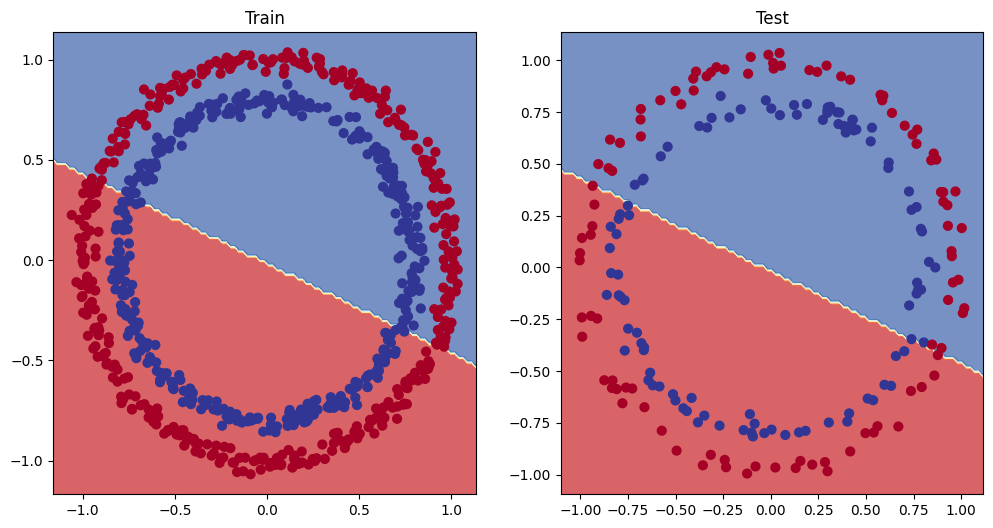

In [106]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

In [107]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]


100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [108]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression), 
    len(y_train_regression), 
    len(X_test_regression), 
    len(y_test_regression))

80 80 20 20


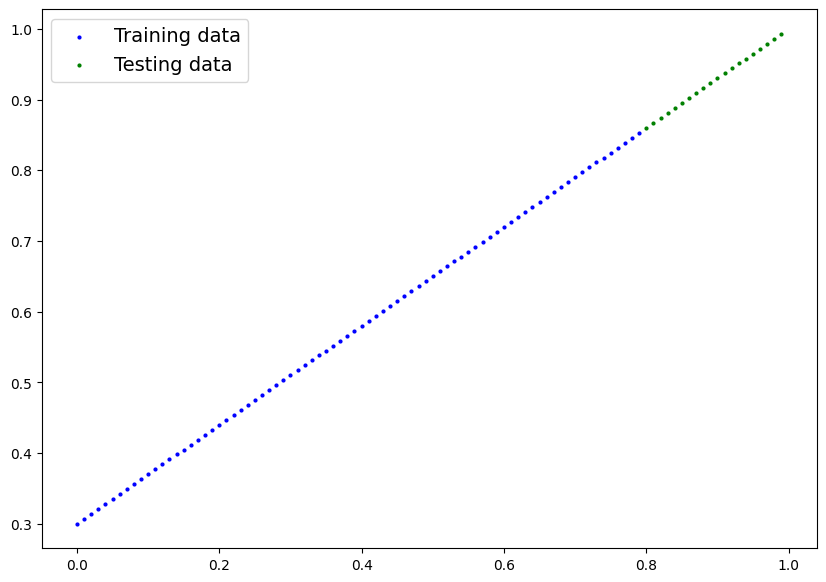

In [116]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
)

In [117]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [118]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [119]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training 
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    
    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss 
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0: 
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05600, Test loss: 0.01425
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


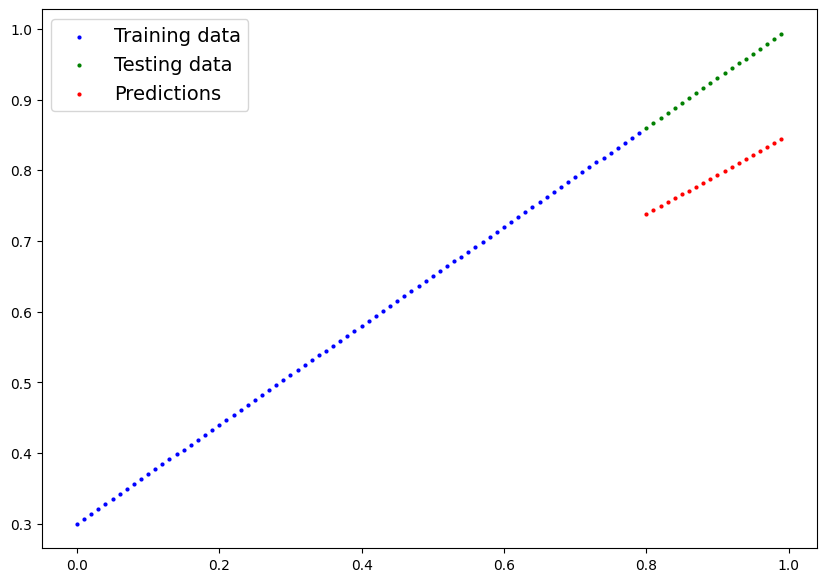

In [120]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

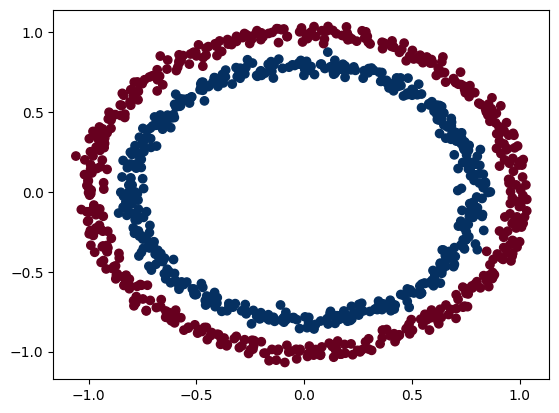

In [121]:


# 6.1 Recreating non-linear data (red and blue circles)
# First, let's recreate the data to start off fresh. We'll use the same setup as before

import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [122]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))


6.2 Building a model with non-linearity
Now here comes the fun part.

What kind of pattern do you think you could draw with unlimited straight (linear) and non-straight (non-linear) lines?

I bet you could get pretty creative.

So far our neural networks have only been using linear (straight) line functions.

But the data we've been working with is non-linear (circles).

What do you think will happen when we introduce the capability for our model to use non-linear actviation functions?

Well let's see.

PyTorch has a bunch of ready-made non-linear activation functions that do similiar but different things.

One of the most common and best performing is [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) (rectified linear-unit, torch.nn.ReLU()).

Rather than talk about it, let's put it in our neural network between the hidden layers in the forward pass and see what happens

In [123]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [124]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [126]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels
    
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train, 
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


In [127]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

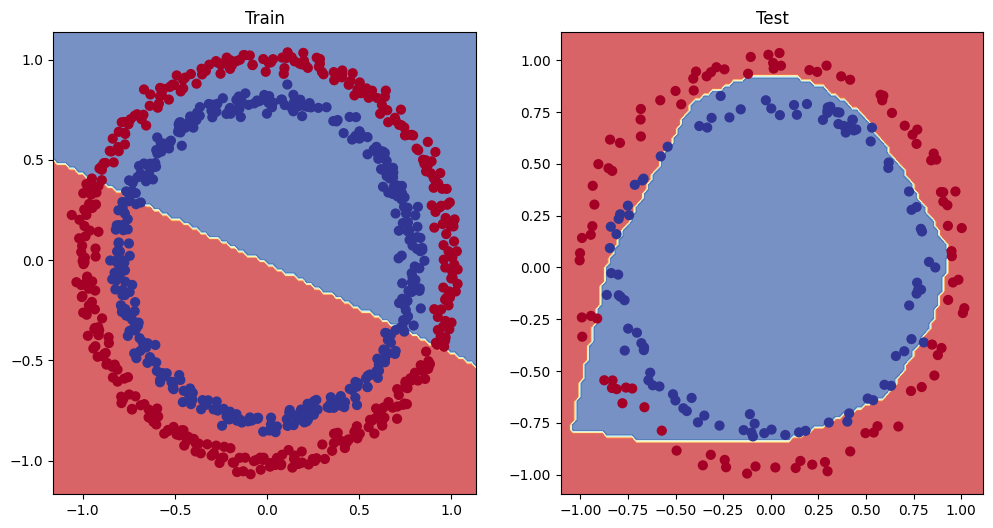

In [128]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity



### 8.1 Creating mutli-class classification data

To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage Scikit-Learn's make_blobs() method.

This method will create however many classes (using the centers parameter) we want.

Specifically, let's do the following:

Create some multi-class data with make_blobs().
Turn the data into tensors (the default of make_blobs() is to use NumPy arrays).
Split the data into training and test sets using train_test_split().
Visualize the data.

tensor([[ -2.6032,  10.4470],
        [  1.2812,   8.2180],
        [-10.4556,   9.8409],
        [-10.2870,   6.5157],
        [ -8.0043,   6.4366]]) tensor([0, 0, 5, 3, 3])


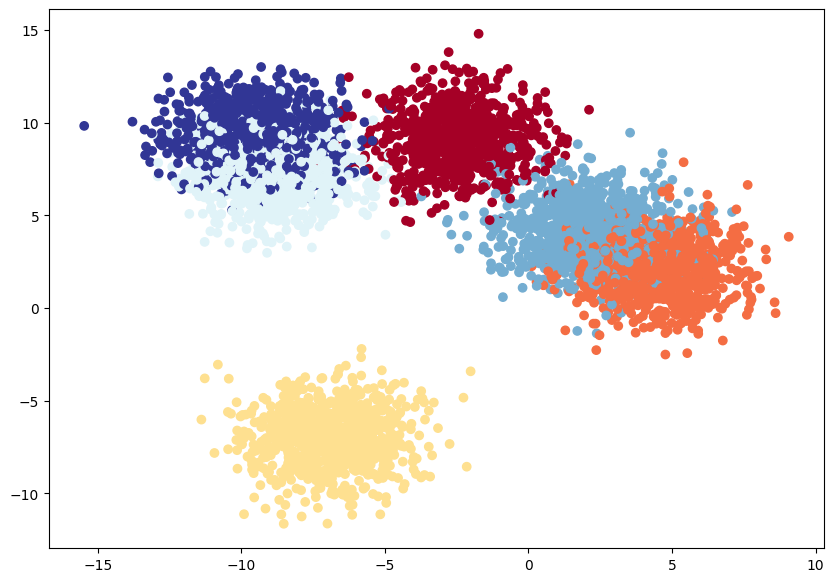

In [194]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 6
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=5000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

Let's build a model to separate the coloured blobs.


### 8.2 Building a multi-class classification model in PyTorch

We've created a few models in PyTorch so far.

You might also be starting to get an idea of how flexible neural networks are.

How about we build one similar to model_3 but this still capable of handling multi-class data?

To do so, let's create a subclass of nn.Module that takes in three hyperparameters:

input_features - the number of X features coming into the model.
output_features - the ideal numbers of output features we'd like (this will be equivalent to NUM_CLASSES or the number of classes in your multi-class classification problem).
hidden_units - the number of hidden neurons we'd like each hidden layer to use.
Since we're putting things together, let's setup some device agnostic code (we don't have to do this again in the same notebook, it's only a reminder)

In [195]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [219]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=6, bias=True)
  )
)

In [220]:
model_4.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('linear_layer_stack',
               Sequential(
                 (0): Linear(in_features=2, out_features=8, bias=True)
                 (1): Linear(in_features=8, out_features=8, bias=True)
                 (2): Linear(in_features=8, out_features=6, bias=True)
               ))])}

### 8.3 Creating a loss function and optimizer for a multi-class PyTorch model
Since we're working on a multi-class classification problem, we'll use the nn.CrossEntropyLoss() method as our loss function.

And we'll stick with using SGD with a learning rate of 0.1 for optimizing our model_4 parameters

In [221]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),  
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

8.4 Getting prediction probabilities for a multi-class PyTorch model

Alright, we've got a loss function and optimizer ready, and we're ready to train our model but before we do let's do a single forward pass with our model to see if it works.

In [222]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4.forward(X_blob_train.to(device))[:5]

tensor([[-1.5195, -0.2094, -1.4327, -0.6655,  0.0215,  0.2053],
        [-1.3149, -0.3648, -1.2296, -0.3861,  0.0226,  0.2445],
        [ 1.6858,  0.8128,  2.2486,  1.1073,  0.7986, -0.7574],
        [ 1.8017,  0.7685,  2.3700,  1.2326,  0.8088, -0.7551],
        [-1.8328, -0.0418, -1.7539, -1.0403,  0.0044,  0.1773]],
       grad_fn=<SliceBackward0>)


Wonderful, our model is predicting one value for each class that we have.

Do you remember what the raw outputs of our model are called?

Hint: it rhymes with "frog splits" (no animals were harmed in the creation of these materials).

If you guessed logits, you'd be correct.

So right now our model is outputing logits but what if we wanted to figure out exactly which label is was giving the sample?

As in, how do we go from logits -> prediction probabilities -> prediction labels just like we did with the binary classification problem?

That's where the softmax activation function comes into play.

The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

If this doesn't make sense, let's see in code.

In [223]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-1.1801, -0.3533, -1.0793, -0.2879,  0.0484,  0.2184],
        [ 1.9961,  0.8453,  2.5954,  1.3290,  0.8592, -0.8202],
        [ 1.8192,  1.0450,  2.4292,  1.0382,  0.8726, -0.8840],
        [ 1.2448, -1.7088,  1.3985,  2.6568,  0.1680,  0.4614],
        [-0.5959, -0.7225, -0.4885,  0.4537,  0.0678,  0.2964]],
       grad_fn=<SliceBackward0>)
tensor([[0.0699, 0.1599, 0.0774, 0.1707, 0.2389, 0.2832],
        [0.2481, 0.0785, 0.4517, 0.1273, 0.0796, 0.0148],
        [0.2373, 0.1094, 0.4367, 0.1087, 0.0921, 0.0159],
        [0.1404, 0.0073, 0.1638, 0.5764, 0.0478, 0.0642],
        [0.0977, 0.0861, 0.1088, 0.2791, 0.1898, 0.2385]],
       grad_fn=<SliceBackward0>)


In [224]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.0699, 0.1599, 0.0774, 0.1707, 0.2389, 0.2832],
       grad_fn=<SelectBackward0>)
tensor(5)



You can see the output of torch.argmax() returns 3, so for the features (X) of the sample at index 0, the model is predicting that the most likely class value (y) is 3.

Of course, right now this is just random guessing so it's got a 25% chance of being right (since there's four classes). But we can improve those chances by training the model.

Note: To summarize the above, a model's raw output is referred to as logits.

For a multi-class classification problem, to turn the logits into prediction probabilities, you use the softmax activation function (torch.softmax).

The index of the value with the highest prediction probability is the class number the model thinks is most likely given the input features for that sample (although this is a prediction, it doesn't mean it will be correct).

#### 8.5 Creating a training and testing loop for a multi-class PyTorch model
Alright, now we've got all of the preparation steps out of the way, let's write a training and testing loop to improve and evaluation our model.

We've done many of these steps before so much of this will be practice.

The only difference is that we'll be adjusting the steps to turn the model outputs (logits) to prediction probabilities (using the softmax activation function) and then to prediction labels (by taking the argmax of the output of the softmax activation function).

Let's train the model for epochs=100 and evaluate it every 10 epochs.

In [229]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 1000

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train) 
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 0.42572, Acc: 79.33% | Test Loss: 0.48209, Test Acc: 74.20%
Epoch: 10 | Loss: 0.42185, Acc: 79.53% | Test Loss: 0.47782, Test Acc: 74.80%
Epoch: 20 | Loss: 0.41820, Acc: 79.65% | Test Loss: 0.47379, Test Acc: 74.90%
Epoch: 30 | Loss: 0.41476, Acc: 79.83% | Test Loss: 0.46998, Test Acc: 75.00%
Epoch: 40 | Loss: 0.41150, Acc: 79.90% | Test Loss: 0.46638, Test Acc: 75.00%
Epoch: 50 | Loss: 0.40842, Acc: 80.00% | Test Loss: 0.46297, Test Acc: 75.60%
Epoch: 60 | Loss: 0.40550, Acc: 80.23% | Test Loss: 0.45974, Test Acc: 76.00%
Epoch: 70 | Loss: 0.40273, Acc: 80.38% | Test Loss: 0.45667, Test Acc: 76.20%
Epoch: 80 | Loss: 0.40010, Acc: 80.60% | Test Loss: 0.45375, Test Acc: 76.40%
Epoch: 90 | Loss: 0.39759, Acc: 80.67% | Test Loss: 0.45097, Test Acc: 76.30%
Epoch: 100 | Loss: 0.39520, Acc: 80.65% | Test Loss: 0.44832, Test Acc: 76.40%
Epoch: 110 | Loss: 0.39293, Acc: 80.83% | Test Loss: 0.44579, Test Acc: 76.80%
Epoch: 120 | Loss: 0.39076, Acc: 81.00% | Test Loss: 0.44338, T

In [235]:
epoch

1000

#### 8.6 Making and evaluating predictions with a PyTorch multi-class model


In [230]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  1.4093,  13.3550, -11.2166, -11.4086,  12.5830, -13.1864],
        [-13.8396,  -2.5100,  20.9328,   9.4049,  -3.5439,   0.3117],
        [-15.4010,   1.3221,  21.2795,   7.3386,  -1.9524,  -2.3698],
        [ 10.3066, -23.8745,  -4.8833,  12.2069,  -5.6339,  13.5575],
        [  3.9385,   3.9135, -10.0324,  -5.5737,   8.0829,  -6.4341],
        [-14.7090,  -0.9225,  21.4207,   8.6746,  -2.9824,  -0.7746],
        [  9.5173,  -8.1738, -12.1371,   0.5748,   3.3502,   1.9519],
        [  4.7274,  20.7042, -20.3157, -18.9354,  18.4081, -19.0257],
        [  4.5918, -21.1861,   2.5050,  13.3654,  -6.5466,  12.1861],
        [  4.8758,  10.8022, -15.2005, -11.4020,  12.5886, -11.6678]])


Alright, looks like our model's predictions are still in logit form.

Though to evaluate them, they'll have to be in the same form as our labels (y_blob_test) which are in integer form.

Let's convert our model's prediction logits to prediction probabilities (using torch.softmax()) then to prediction labels (by taking the argmax() of each sample).

Note: It's possible to skip the torch.softmax() function and go straight from predicted logits -> predicted labels by calling torch.argmax() directly on the logits.

For example, y_preds = torch.argmax(y_logits, dim=1), this saves a computation step (no torch.softmax()) but results in no prediction probabilities being available to use.

In [231]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 2, 2, 5, 4, 2, 0, 1, 3, 4])
Labels: tensor([1, 2, 2, 5, 4, 2, 0, 1, 3, 4])
Test accuracy: 84.2%


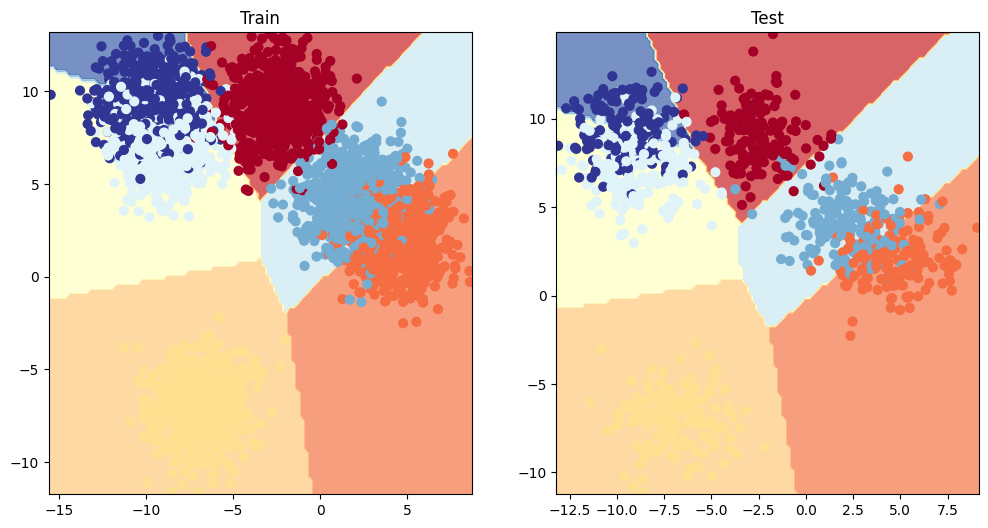

In [232]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### 9. More classification evaluation metrics
So far we've only covered a couple of ways of evaluating a classification model (accuracy, loss and visualizing predictions).

These are some of the most common methods you'll come across and are a good starting point.

However, you may want to evaluate you classification model using more metrics such as the following:


Accuracy:  
Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct.	

`torchmetrics.Accuracy() or sklearn.metrics.accuracy_score()`

Precision: 

Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).	

`torchmetrics.Precision() or sklearn.metrics.precision_score()`

Recall	:

Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.

`torchmetrics.Recall() or sklearn.metrics.recall_score()`

F1-score :

Combines precision and recall into one metric. 1 is best, 0 is worst.	

`torchmetrics.F1Score() or sklearn.metrics.f1_score() `

Confusion matrix :

Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line).

`torchmetrics.ConfusionMatrix or sklearn.metrics.plot_confusion_matrix()`

Classification report:

Collection of some of the main classification metrics such as precision, recall and f1-score.	

`sklearn.metrics.classification_report()`

In [144]:
! pip install torchmetrics

     ---------------------------------------- 0.0/519.2 kB ? eta -:--:--
     -- ------------------------------------ 30.7/519.2 kB 1.4 MB/s eta 0:00:01
     ------ -------------------------------- 92.2/519.2 kB 1.1 MB/s eta 0:00:01
     ---------- --------------------------- 143.4/519.2 kB 1.1 MB/s eta 0:00:01
     ----------------- -------------------- 235.5/519.2 kB 1.4 MB/s eta 0:00:01
     -------------------------------- ----- 450.6/519.2 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 519.2/519.2 kB 1.9 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [237]:
from torchmetrics import Accuracy
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=6).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.8420)